In [1]:
model_name="pseudo"
window_size = 0
overlap = 0
sample = 1

prefix=f"{model_name.replace('/','')}_sample_{sample}"

In [2]:
import RevPrep

In [3]:
from RevPrep.Generation.generate.base import generate , get_model_tokenizer
from RevPrep.Evaluations.scoring import analyse_sentiment, df_sentiment_model, df_sentiment_review, df_sentiments_model, df_sentiments_review, cal_rouge, cal_bert_score, import_bert_scores, cal_readability
from RevPrep.plotting import plot

In [4]:
import pandas as pd

In [5]:
import pickle as pkl
import glob
from tqdm.notebook import tqdm 

In [6]:
sample_big = pkl.load(open(f"benchmark_sample{sample}_big.pkl","rb"))
sample_small = pkl.load(open(f"benchmark_sample{sample}_small.pkl","rb"))

In [7]:
from RevPrep.Evaluations.scoring import cal_compression_rate
from RevPrep.Helpers.helpers import text_to_words

In [8]:
len_big = [len(text_to_words(i)) for i in sample_big]
len_short = [len(text_to_words(i)) for i in sample_small]

In [9]:
results_window = {}
results_window["generated summaries"] = sample_small
results_window["source_texts"] = sample_big

In [10]:
cal_compression_rate(len_big, len_short)

(0.40617723361537067, 0.05476320320854699)

In [11]:
import importlib
importlib.reload(RevPrep.Evaluations.scoring)
importlib.reload(RevPrep.plotting.plot)

<module 'RevPrep.plotting.plot' from '/mnt/01D64EB52A75D220/Users/Science/Documents/Projekte/MA/code/RevPrep/plotting/plot.py'>

In [12]:
sens = analyse_sentiment(results_window, 5,30)

PyTorch version 1.6.0 available.
TensorFlow version 2.3.1 available.


#### Plot the Means, created by the model of each summary gen and original

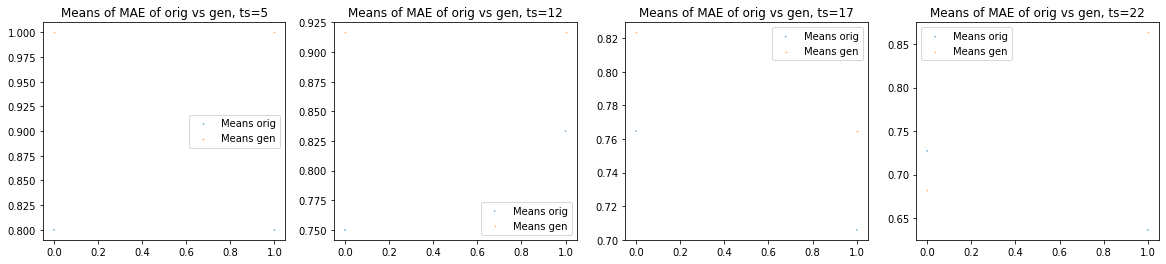

In [13]:
plot.plot_sentiment_means([sens[5], sens[12], sens[17], sens[22]], first_n=2)

### Plot the sentiment function of each summary gen and original 

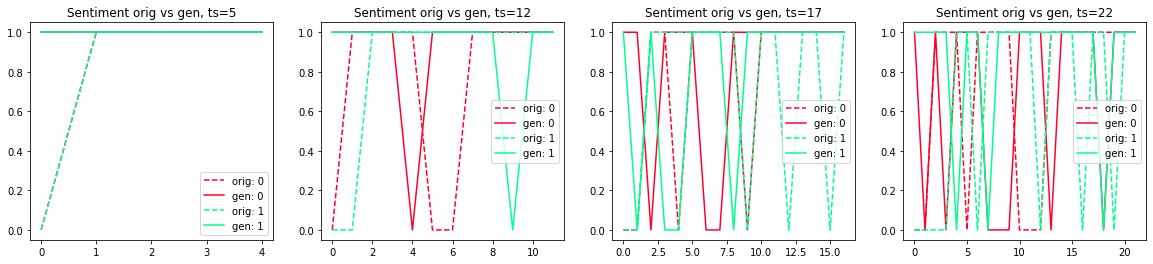

In [14]:
plot.plot_sentiment_functions([sens[5], sens[12], sens[17], sens[22]], first_n=2)

### Plot the progress of the mean squared error, which shows the deviation of both functions

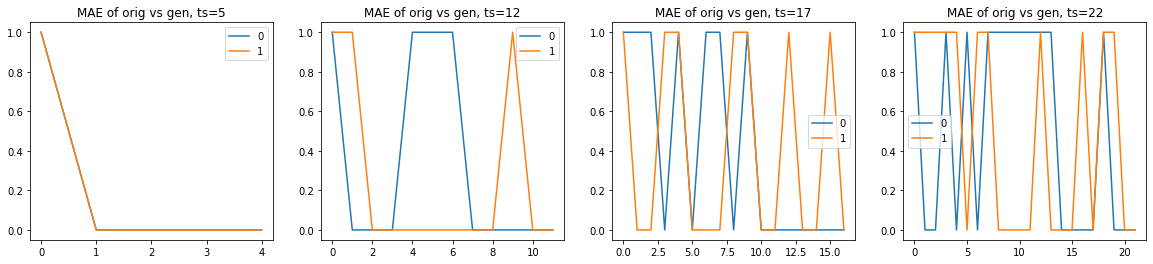

In [15]:
plot.plot_sentiment_mae([sens[5], sens[12], sens[17], sens[22]], first_n=2)

### Print how each summary has been sentimented for gen and original and take the mean of these values. This is an indicator, whether the generated review has the same sentiment as the original in average (without information if the different sentiments are well pictured, for this, see below)

In [16]:
df_sentiments_review(sens)

,means_orig,means_gen,difference
0,0.772608,0.777651,0.005043
1,0.724954,0.838490,0.113536
2,0.251752,0.495743,0.243992
3,0.486435,0.886624,0.400189
4,0.755300,0.742405,0.012895
...,...,...,...
295,0.630404,0.630388,0.000016
296,0.775489,0.613910,0.161579
297,0.434969,0.774920,0.339951
298,0.787329,0.677571,0.109758


### Print the Sum of all Mse-means and Mse-Variances, which will be used for comparing to other models how well the progress of the sentiment is pictured by the generated summary

In [17]:
df_sentiments_model(sens)

mae mean                0.406545
mae std dev             0.152406
sum of mae-mean       121.963628
Sum of mae-std-dev    136.979520
dtype: float64

# Rouge Score 

In [18]:
mean_rouge, std_dev_rouge, _ = cal_rouge(results_window["generated summaries"], results_window["source_texts"])

In [19]:
print(mean_rouge)
print(std_dev_rouge)

{'r1-f1': 0.34484213121648183, 'r1-p': 0.5999700340753304, 'r1-r': 0.24326818704184527, 'r2-f1': 0.07141471061240358, 'r2-p': 0.12448107674904361, 'r2-r': 0.05034375930240538, 'rl-f1': 0.27062018158940776, 'rl-p': 0.40869625004632726, 'rl-r': 0.2037684289464485}
{'r1-f1': 0.03415503862040942, 'r1-p': 0.037860216932898115, 'r1-r': 0.03173503866673081, 'r2-f1': 0.01434115602954321, 'r2-p': 0.023328213399957914, 'r2-r': 0.010968475421097622, 'rl-f1': 0.03490565251862038, 'rl-p': 0.04911787226907786, 'rl-r': 0.03226520905480798}


# Bert-Score 

In [20]:
cal_bert_score(results_window["generated summaries"], results_window["source_texts"], prefix=prefix)
mean_bs, stddev_bs, _ = import_bert_scores(prefix=prefix)
print(mean_bs)
print(stddev_bs)

/home/science/anaconda3/envs/tr_pegasus_env/lib/python3.7/site-packages/transformers/configuration_xlnet.py:211: FutureWarning: This config doesn't use attention memories, a core feature of XLNet. Consider setting `men_len` to a non-zero value, for example `xlnet = XLNetLMHeadModel.from_pretrained('xlnet-base-cased'', mem_len=1024)`, for accurate training performance as well as an order of magnitude faster inference. Starting from version 3.5.0, the default parameter will be 1024, following the implementation in https://arxiv.org/abs/1906.08237
  FutureWarning,



{'f1': 0.6186846, 'p': 0.6564869, 'r': 0.58540463}
{'f1': 0.01779486, 'p': 0.021237064, 'r': 0.02126369}


# Readability

In [21]:
means_rb, std_dev_rb = cal_readability(results_window["generated summaries"], results_window["source_texts"])

# Result Summary: 

In [22]:
mean_orig_avg = df_sentiments_review(sens).agg("mean")["means_orig"]
mean_gen_avg = df_sentiments_review(sens).agg("mean")["means_gen"]
mean_difference = df_sentiments_review(sens).agg("mean")["difference"]
stddev_difference = df_sentiments_review(sens).agg("std")["difference"]

In [23]:
sum_mae = df_sentiments_model(sens)["sum of mae-mean"]
sum_std_dev_mae_means = df_sentiments_model(sens)["Sum of mae-std-dev"]
mean_mae = df_sentiments_model(sens)["mae mean"]
std_dev_mae_means = df_sentiments_model(sens)["mae std dev"]

In [24]:
r1pm = mean_rouge["r1-p"]
r1rm = mean_rouge["r1-r"]
r1fm = mean_rouge["r1-f1"]

r2pm = mean_rouge["r2-p"]
r2rm = mean_rouge["r2-r"]
r2fm = mean_rouge["r2-f1"]

rlpm = mean_rouge["rl-p"]
rlrm = mean_rouge["rl-r"]
rlfm = mean_rouge["rl-f1"]

r1ps = std_dev_rouge["r1-p"]
r1rs = std_dev_rouge["r1-r"]
r1fs = std_dev_rouge["r1-f1"]

r2ps = std_dev_rouge["r2-p"]
r2rs = std_dev_rouge["r2-r"]
r2fs = std_dev_rouge["r2-f1"]

rlps = std_dev_rouge["rl-p"]
rlrs = std_dev_rouge["rl-r"]
rlfs = std_dev_rouge["rl-f1"]

In [25]:
bspm = mean_bs["p"]
bsrm = mean_bs["r"]
bsfm = mean_bs["f1"]

bsps = stddev_bs["p"]
bsrs = stddev_bs["r"]
bsfs = stddev_bs["f1"]

In [26]:
data_r_m = {"mR1-p": r1pm, "mR1-r": r1rm, "mR1-f1": r1fm, "mR2-p":r2pm, "mR2-r": r2rm," mR2-f1": r2fm, "mRl-p": rlpm, "mRl-r": rlrm, "mRl-f1": rlfm,}

In [27]:
data_r_s = {"sR1-p": r1ps, "sR1-r": r1rs, "sR1-f1": r1fs, "sR2-p":r2ps, "sR2-r": r2rs, "sR2-f1": r2fs, "sRl-p": rlps, "sRl-r": rlrs, "sRl-f1": rlfs}

In [28]:
data_bs = {"bs-mean F1": bsfm, "bs-mean P": bspm, "bs-mean R": bsrm, "bs-std-dev F1": bsfs, "bs-std-dev P": bsps, "bs-std-dev R": bsrs}

In [29]:
data_sentiment = {"Sen. rev. mean orig": mean_orig_avg, "Sen. rev. mean gen": mean_gen_avg, "Sen. rev. diff mean": mean_difference, \
                  "Sen. rev. diff stddev": stddev_difference,
                  "Sen. mae sum": sum_mae, "Sen. mae std.": sum_std_dev_mae_means, "Sen. mae avg": mean_mae, "Sen mae std dev avg": std_dev_mae_means}

In [30]:
results_sen = pd.DataFrame(data=data_sentiment, index=[model_name])

In [31]:
results_rouge_mean = pd.DataFrame(data=data_r_m, index=[model_name])

In [32]:
results_rouge_std_dev = pd.DataFrame(data=data_r_s, index=[model_name])

In [33]:
results_bert = pd.DataFrame(data=data_bs, index=[model_name])

In [34]:
results_rb_means = pd.DataFrame(data=means_rb, index=[model_name])
results_rb_std_dev = pd.DataFrame(data=std_dev_rb, index=[model_name])

In [35]:
pkl.dump(results_sen, open(f"benchmark_results/sentimentanalysis/{prefix}.pkl", "wb"))
pkl.dump(results_rouge_mean, open(f"benchmark_results/rougemean/{prefix}.pkl", "wb"))
pkl.dump(results_rouge_std_dev, open(f"benchmark_results/rougestddev/{prefix}.pkl", "wb"))
pkl.dump(results_bert, open(f"benchmark_results/bertscore/{prefix}.pkl", "wb"))
pkl.dump(results_rb_means, open(f"benchmark_results/readabilitymean/{prefix}.pkl", "wb"))
pkl.dump(results_rb_std_dev, open(f"benchmark_results/readabilitystddev/{prefix}.pkl", "wb"))

In [36]:
results_sen

,Sen. rev. mean orig,Sen. rev. mean gen,Sen. rev. diff mean,Sen. rev. diff stddev,Sen. mae sum,Sen. mae std.,Sen. mae avg,Sen mae std dev avg
pseudo,0.685655,0.66881,0.147157,0.111574,121.963628,136.97952,0.406545,0.152406


In [37]:
results_rouge_mean

,mR1-p,mR1-r,mR1-f1,mR2-p,mR2-r,mR2-f1,mRl-p,mRl-r,mRl-f1
pseudo,0.59997,0.243268,0.344842,0.124481,0.050344,0.071415,0.408696,0.203768,0.27062


In [38]:
results_rouge_std_dev

,sR1-p,sR1-r,sR1-f1,sR2-p,sR2-r,sR2-f1,sRl-p,sRl-r,sRl-f1
pseudo,0.03786,0.031735,0.034155,0.023328,0.010968,0.014341,0.049118,0.032265,0.034906


In [39]:
results_bert

,bs-mean F1,bs-mean P,bs-mean R,bs-std-dev F1,bs-std-dev P,bs-std-dev R
pseudo,0.618685,0.656487,0.585405,0.017795,0.021237,0.021264


In [40]:
results_rb_means

,Flesch ease mean gen,Flesch ease mean orig,Flesch ease mean diff,Flesch grade mean gen,Flesch grade mean orig,Flesch grade mean diff,Dale Chall Readability V2 mean gen,Dale Chall Readability V2 mean orig,Dale Chall Readability V2 mean diff
pseudo,75.595933,74.9475,7.795167,7.152,7.395333,2.144667,6.429167,6.337467,0.5277


In [41]:
results_rb_std_dev

,Flesch ease std dev gen,Flesch ease std dev orig,Flesch ease std dev diff,Flesch grade std dev gen,Flesch grade std dev orig,Flesch grade std dev diff,Dale Chall Readability V2 std dev gen,Dale Chall Readability V2 std dev orig,Dale Chall Readability V2 std dev diff
pseudo,8.559424,8.438643,6.687051,2.276612,2.233214,1.983668,0.5429,0.678011,0.558383
